In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# def poly(x):
#     return (-0.001 * x**6 + 0.003 * x**5 + 0.062 * x**4 - 
#             0.174 * x**3 - 0.673 * x**2 + 1.323 * x + 1.764)
def poly(x):
  """
  A 1D function with multiple distinct extrema of varying heights.
  """
  gaussian1 = 2 * np.exp(-((x + 3)**2) / 2)
  gaussian2 = 3 * np.exp(-((x - 1)**2) / 1)
  gaussian3 = 1.5 * np.exp(-((x - 4)**2) / 1.5)
  sin_wave = 0.3 * np.sin(2 * x)
  return gaussian1 + gaussian2 + gaussian3 + sin_wave

def plot_2d_acq_func(train_x, train_y, acq_f_name, model, black_box_func=None, bounds=(-5,5), iter_n=0):
    '''
    Input:
    train_x = tensor of train x data in 2D array format.
    train_y = tensor of train y data in 2D array format.
    acq_func = A string belonging to the following set {'LogEI', 'UCB', 'LogPI'}.
    model = Trained gaussian process regressor from the BOTorch library.
    bounds = Tuple consisting of upper and lower bounds for plotting and optimizing.
    black_box_func = Optional true black_box function for plotting purposes.

    output:
    2 plots:
    1st one shows the regressor, black box function (optional), 
    recommended candidate point from bayesian optimization and previously taken sample points
    against their respective y-values.
    2nd one is a plot of the given acquisition function.
    '''
    plt.rcParams['text.usetex'] = True

    title = 'Surrogate'
    plot_x = np.linspace(bounds[0],bounds[1],1000)
    plot_x_tensor = torch.tensor(plot_x.reshape(-1,1))

    acq_dict={
        'LogEI': [LogExpectedImprovement, train_y.max()],
        'UCB': [UpperConfidenceBound, 0.1],
        'LogPI': [ProbabilityOfImprovement, train_y.max()],
    }

    acq_func = acq_dict[acq_f_name][0](model, acq_dict[acq_f_name][1])
    
    bounds = torch.stack([bounds[0] * torch.ones(1), bounds[1] * torch.ones(1)]).to(torch.double)
    candidate, acq_value = optimize_acqf(acq_func, bounds=bounds, 
                                         q=1, num_restarts=5, raw_samples=20,)

    plot_acq_func = acq_func(plot_x_tensor.unsqueeze(-2)).detach().numpy()

    with torch.no_grad():
        model_mean = model.posterior(plot_x_tensor).mean

    fig, axs = plt.subplots(2, figsize=(7,7))
    if black_box_func != None:
        plot_y = black_box_func(plot_x)
        axs[0].plot(plot_x_tensor.numpy(), plot_y, 
                    label="Black box function", color="red")
        title += ', Black Box function'
    title += r' vs. respective $y$-values'

    axs[0].plot(plot_x_tensor.numpy(), model_mean.numpy(), 
                label="GP Mean", color="blue", linestyle='dashed')
    
    if iter_n >0:
        axs[0].scatter(train_x[:-1],train_y[:-1], color = 'orange', label="Sample points")
        axs[0].scatter(train_x[-1],train_y[-1], color = 'red', label="Sample points from last iteration")
    else:
        axs[0].scatter(train_x,train_y, color = 'orange', label="Sample points")        
    axs[0].scatter(candidate, black_box_func(candidate), label="candidate point", 
                   color = 'green')

    axs[1].plot(plot_x_tensor.numpy(), plot_acq_func, label=acq_f_name, color="orange", lw=2)
    axs[1].scatter(candidate, acq_value, 
                   color = 'green')
    
    fig.subplots_adjust(hspace=0.5)
    fig.legend(loc='center',bbox_to_anchor=(1.05, 0.5))
    axs[0].set_title(title)
    fig.suptitle(f'Bayesian Optimization at iteration {iter_n}')
    axs[1].set_title(f'Acquisition function {acq_f_name} evaluated at '+r'$x$')

    axs[0].set_ylabel('Yield')
    axs[1].set_ylabel(f'{acq_f_name}'+r'$(x)$')
    axs[0].set_xlabel(r'variable $x$')
    axs[1].set_xlabel(r'variable $x$')

    plt.show()
    return candidate

In [281]:
train_x[-1]

tensor([-5.], dtype=torch.float64)

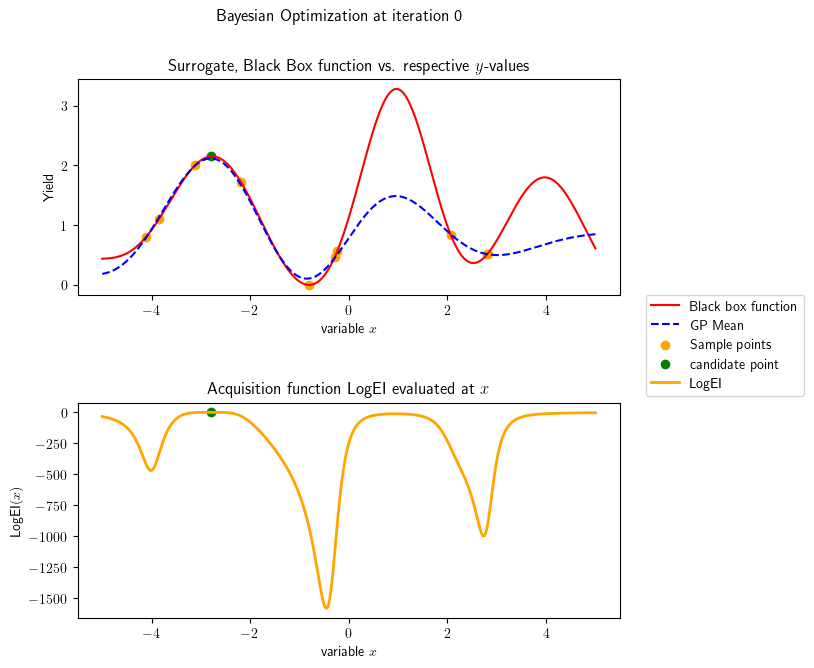

In [297]:
train_x_np = np.random.uniform(low=-5, high=5, size=10)
train_y_np = poly(train_x_np)

train_x = torch.tensor(train_x_np.reshape(-1,1))
train_y = torch.tensor(train_y_np.reshape(-1,1))

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)
    
candidate = plot_2d_acq_func(train_x, train_y, 'LogEI', gp, poly)

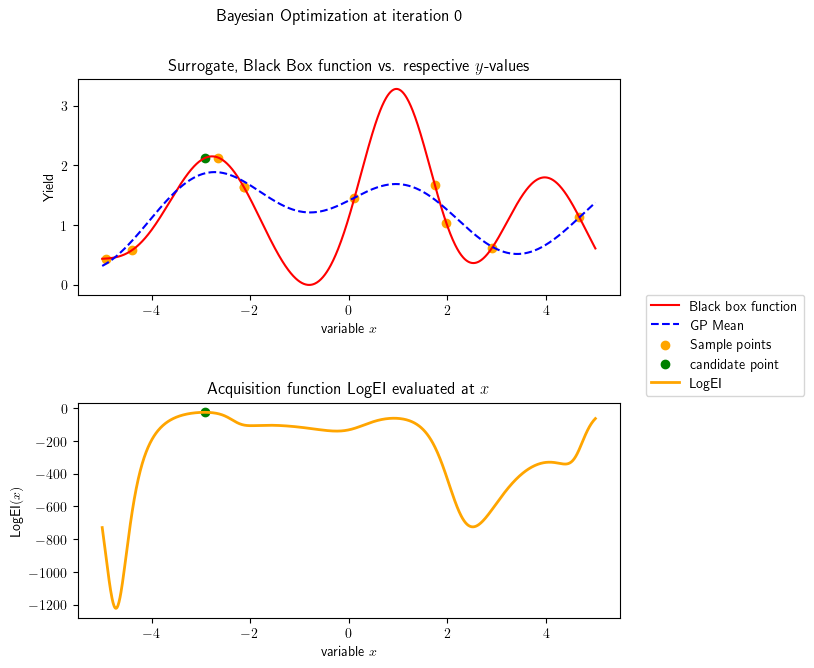

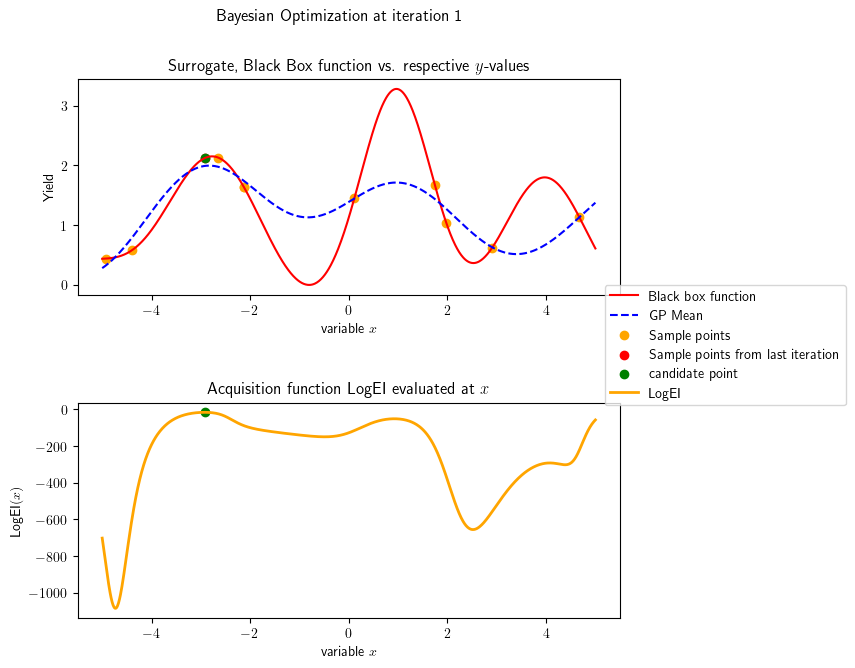

In [ ]:

train_x_np = np.random.uniform(low=-5, high=5, size=10)
train_y_np = poly(train_x_np)
for i in range(2):

    train_x = torch.tensor(train_x_np.reshape(-1,1))
    train_y = torch.tensor(train_y_np.reshape(-1,1))

    gp = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        input_transform=Normalize(d=1),
        outcome_transform=Standardize(m=1),
    )
    
    candidate = plot_2d_acq_func(train_x, train_y, 'LogEI', gp, poly, iter_n=i)

    train_x_np = np.array(list(train_x_np) + [(float(candidate[0,0]))])
    train_y_np = np.array(list(train_y_np) + [poly(float(candidate[0,0]))])

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from botorch.models import SingleTaskGP
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
from botorch.models.transforms import Normalize, Standardize
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from gpytorch.likelihoods import GaussianLikelihood

# Step 1: Generate 2D synthetic training data
torch.manual_seed(42)  # For reproducibility
train_X = torch.rand(10, 2) * 10 - 5  # 10 points in [-5,5] x [-5,5]
train_Y1 = torch.sin(train_X[:, 0]) + torch.cos(train_X[:, 1]) + 0.1 * torch.randn(10)
train_Y2 = torch.cos(train_X[:, 0]) - torch.sin(train_X[:, 1]) + 0.1 * torch.randn(10)
train_Y = torch.stack([train_Y1, train_Y2], dim=-1)  # Multi-objective outputs

# Step 2: Define GP Model
gp = SingleTaskGP(
    train_X,
    train_Y,
    input_transform=Normalize(d=2),
    outcome_transform=Standardize(m=2),
)
gp.eval()

# Step 3: Define Reference Point (for Hypervolume Calculation)
ref_point = train_Y.min(dim=0).values - 0.1  # Slightly below the minimum observed

# Step 4: Define EHVI Acquisition Function
partitioning = NondominatedPartitioning(ref_point=ref_point, Y=train_Y)
ehvi = qExpectedHypervolumeImprovement(model=gp, ref_point=ref_point.tolist(), partitioning=partitioning)

# Step 5: Generate a 2D grid for plotting
X1 = torch.linspace(-5, 5, 30)
X2 = torch.linspace(-5, 5, 30)
X1_mesh, X2_mesh = torch.meshgrid(X1, X2, indexing="ij")
X_grid = torch.cat([X1_mesh.reshape(-1, 1), X2_mesh.reshape(-1, 1)], dim=1)

# Step 6: Compute EHVI over the grid
with torch.no_grad():
    EHVI_values = ehvi(X_grid).reshape(30, 30)  # Reshape for 3D plotting

# Step 7: 3D Plot of EHVI
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_mesh.numpy(), X2_mesh.numpy(), EHVI_values.numpy(), cmap="viridis", alpha=0.8)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("EHVI")
ax.set_title("Expected Hypervolume Improvement (EHVI)")

plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_31704\1202284431.py:20: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\botorch\acquisition\multi_objective\monte_carlo.py:111: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\linear_operator\utils\cholesky.py:40: